# Trotter Extrapolation

## James D. Watson, Jacob Watkins
## August 2023

### TODO:

- Generalize Trotter code to any order formula (currently first and second order)
- Conduct systematic computations of error and complexity

## Theory

From Equation (1) of [this text](https://arxiv.org/abs/1711.10980), we want to simulate the 1D Heisenberg model.

$$
H = \sum_{i=1}^n \sigma_i \cdot \sigma_{i+1} + h_j \sigma_j^z
$$

with $h_j \in [-h,h]$ randomly and uniformly sampled. Suppose we wish to simulate $e^{-i H T}$ on a quantum computer using product formulas. A natural choice is to split according to even-odd staggering of the interaction term, and then do the $Z$ rotations in their own grouping. If $n$ is odd, there will be one term left over. I don't think we should fret, probably just choose even $n$ for simplicity since we are only exploring our method. 

In [67]:
# Imports

import numpy as np
import scipy.interpolate as interp
import scipy.linalg as sla
import numpy.linalg as nla
import matplotlib.pyplot as plt
import random as rand

## Useful Pauli and qubit manipulations

In [2]:
# Computes Kronecker (tensor) product of a list of matrices
# Example:
# Input: [X,Y,Z,Y]
# Return: X \ox Y \ox Z \ox Y
def kron_list(matrix_list):
    result = matrix_list[0]
    for i in range(1,len(matrix_list)):
        result = np.kron(result,matrix_list[i])
        
    return result

# Pauli matrices
I = np.array([[1.,0],[0,1.]], dtype='complex')
X = np.array([[0,1.],[1.,0]], dtype='complex')
Y = np.array([[0,-1.j],[1.j,0]], dtype='complex')
Z = np.array([[1.,0],[0,-1.]], dtype='complex')

# Converts string representation of paulis to list of matrices,
# Example:
# Input: "XYZY"
# Return: [X,Y,Z,Y]
def paulistring_to_list(paulistring): 
    matrix_list = list(paulistring)
    translate = {'I':I, 'X':X, 'Y':Y, 'Z':Z}
    for p in range(len(paulistring)):
        matrix_list[p] = translate[matrix_list[p]]
    return matrix_list

# Computes generalized pauli matrix, given a string in standard form,
# Example:
# Input: "XYZY"
# Return: X \ox Y \ox Z \ox Y
def pauli_matrix(paulistring):
    return kron_list(paulistring_to_list(paulistring))

# Computes generalized pauli matrix, specified by non-identity pieces. Nonidentities encoded as dictionary
# of the form {k:'P', ..., } where k is the integer location and P is a pauli
# Example:
# Input: {0: 'X', 3:'Z', 5:'X'}, 6
# Return: X\ox I \ox  Z \ox I \ox I \ox X
def sparse_pauli(nonidentities, nqubits):
    #starting string is all identity
    paulilist = []
    for i in range(0, nqubits):
        paulilist.append('I')
    
    #Change string to paulis specified by dictionary
    for key in nonidentities:
        paulilist[key] = nonidentities[key]
    paulistring = ''.join(paulilist)
    
    return pauli_matrix(paulistring) 

# Returns the matrix of \sigma . \sigma between sites i and j
# Example:
# Input: 0,1,4
# Return: X\ox X \ox I \ox I + Y\ox Y \ox I \ox I + Z\ox Z \ox I \ox I
def sigma_dot_sigma(i,j,nqubits):
    return sparse_pauli({i:'X',j:'X'},nqubits) + sparse_pauli({i:'Y',j:'Y'},nqubits) + sparse_pauli({i:'Z',j:'Z'},nqubits)

# Qubit computational basis
zero = np.array([1.,0], dtype ='complex')
one = np.array([0,1.], dtype ='complex')

# Converts a bitstring to list of single-qubit kets
# Example: 
# Input: "0101"
# Output: list( (1,0), (0,1), (1,0), (0,1) )
def bitstring_to_list(bitstring):
    bitlist = list(bitstring)
    translate = {'0':zero, '1':one}
    for b in range(len(bitstring)):
        bitlist[b] = translate[bitlist[b]]
    return bitlist

# Converts a bitstring to full vector/array describing each qubit.
# Example: 
# Input: "0101"
# Output:  (1,0) \ox (0,1) \ox (1,0) \ox (0,1) 
def basis_ket(bitstring):
    return kron_list(bitstring_to_list(bitstring))


# Outputs a bit string with certain positions set to 1, and otherwise set to zero.
# Example: 
# Input: [0,1,2],3
# Output:  (0,0,0,0,0,0,0,0,1)
def sparse_bitstring(ones, nqubits):
    bitlist = ['0']*nqubits
    
    #Flip certain bits to one, as specified by list of qubit indices
    for qubit in ones:
        bitlist[qubit] = '1'
    
    # Convert list to bitstring
    bitstring = ''.join(bitlist)
    
    return basis_ket(bitstring)

## Simulation functions

In [3]:
# Given: a positive integer, nqubits, and a list of n floats, hlist
# Generates the 1D Heisenberg chain Hamiltonian specified in the introduction.
def heisenbergH(nqubits, hlist):
    H = sigma_dot_sigma(0,1,nqubits) + hlist[0]*sparse_pauli({0:'Z'}, nqubits)
    for j in range(1, nqubits):
        H += sigma_dot_sigma(j, (j+1)%nqubits, nqubits) + hlist[j]*sparse_pauli({j:'Z'}, nqubits)
    return H

# Given a square matrix H and float T
# Returns the exact time evolution operator e^{-i H T} 
def Uexact(H, T):
    return sla.expm(-1.j*H*T)

# Computes a single time step of first or second order Trotter
# Terms in Hterms are applied to the state in increasing index (0,1,...,m)
def Utrot_short(Hterms, t, order = 1):
    m = len(Hterms) # number of terms
    result = sla.expm(-1.j*Hterms[m-1]*t)
    if order == 1:  
        for k in range(m-2,-1,-1):
            result = result @ sla.expm(-1.j*Hterms[k]*t)
    
    elif order == 2: 
        for k in range(m-2, -1, -1):
            result = sla.expm(-1.j*Hterms[k]*t/2) @ result @ sla.expm(-1.j*Hterms[k]*t/2)
    else:
        raise ValueError("Not a valid order of Trotter formula: must be 1 or 2")
    return result
    
# Given: a list Hterms of square matrices of same dimension, float T, a (possibly noninteger) number of steps, and order =1,2
# Returns a Trotter evolution of given order and step number, for time T
def Utrot_long(Hterms, T, steps, order = 1):
    single_step = Utrot_short(Hterms, T/steps, order)
    
    integer_steps = int( np.floor(steps) )
    fractional_step = steps - integer_steps
    
    integer_step_evolve = nla.matrix_power(single_step, integer_steps)
    fractional_step_evolve = sla.fractional_matrix_power(single_step, fractional_step)
    
    total_evolution = integer_step_evolve @ fractional_step_evolve 
    
    return total_evolution

## Generate Breakdown of the Heisenberg Hamiltonian

In [92]:
## Define the even, odd and potential terms for an arbitrary nunber of qubits and a given hlist.

def Even_Heisenberg_Terms(nqubits):
    Even = sigma_dot_sigma(0, 1, nqubits)
    for j in range(2,nqubits,2):
        Even += sigma_dot_sigma(j, (j+1)%nqubits, nqubits)
        
    return Even

def Odd_Heisenberg_Terms(nqubits):
    
    Odd = sigma_dot_sigma(1, 2%nqubits, nqubits)
    for j in range(3,nqubits,2):
        Odd += sigma_dot_sigma(j, (j+1)%nqubits, nqubits)
        
        
    return Odd

def Potential_Heisenberg_Terms(nqubits, hlist):
    
    Potential = np.sum([hlist[j]*sparse_pauli({j:'Z'}, nqubits) for j in range(nqubits)], axis = 0)
        
    return Potential





## Local Observable and Expectation Value Functions

In [84]:
## Define a Local Observable:

## Computes  Hermitian observable, specified by Pauli strings. Input is a list of dictionaries: nonidentities encoded as dictionary
## of the form {k:'P', ..., } where k is the integer location and P is a pauli. Pauli strings are then input as list.
# Example:
# Input: [{0: 'X', 3:'Z', 5:'X'}, {1: 'X'}], 6
# Return: X\ox I \ox  Z \ox I \ox I \ox X + I\ox X \ox  I \ox I \ox I \ox I
def observable(List_Pauli_strings, nqubits):

    local_observable = 0
    for k in range(len(List_Pauli_strings)):
        local_observable +=  sparse_pauli( List_Pauli_strings[k], nqubits )
    
    return local_observable

## Take expectation value of 'observable' with respect to to 'state'
# Example:
# Input: sparse_bitstring([0], 1), observable([{0: 'Z'}], 1) 
# Output: -1
def expectation_value(state, observable):
    
    normalisation =   np.vdot(state, state )  
    # Throw an exception if the state is not normalised.
    if (normalisation -1) > 0.00001:
        raise ValueError("State is not normalised")
    
    # Calculate the expectation of the state. Use vdot to get complex conjugate.
    expectation = np.vdot(state, observable.dot(state) )
    
    # Throw an exception if there is a significant imaginary part to the expectation value.
    if np.abs(expectation.imag) > 0.00001:
        raise ValueError("Expectation value should be entirely real")
        
    # Return only the real part of the expectation value (imaginary part should be zero).
    return np.real(expectation)

## Finds the expectation value with respect to the Trotterized time evolution. Define the function in terms of s = 1/steps.
# Example: 
# Input: [Even, Odd, Potential], sparse_bitstring([0,1], 2), 10, 0.01, observable([{0: 'Z'}], 2) 
# Output: -1 + 0.j
def Trotterized_Expectation(Hterms, initial_state, time, s, observable, order = 1):
    
    steps = 1/s
    
    # Calculate the Trotterized time-evolution operator and apply to the initial state.
    Trotterized_evolution_operator = Utrot_long(Hterms, time, steps, order)
    time_evolved_state = Trotterized_evolution_operator @ initial_state
    
    return expectation_value(time_evolved_state, observable)
    
## Computes the time-evolved expectation value from the *exact* evolution.  
# Example: 
# Input: heisenbergH(nqubits, hlist), sparse_bitstring([0,1], 2), 10, observable([{0: 'Z'}], 2) 
# Output: -1 + 0.j
def Exact_Expectation(Hamiltonian, initial_state, time, observable):
    
    # Calculate the exact evolution operator.
    evolution_operator = Uexact(Hamiltonian, time)
    # Apply the exact evolution to the initial state.
    time_evolved_state = evolution_operator @ initial_state
    
    return expectation_value(time_evolved_state, observable)

## Computes the magnetisation as a matrix.
# Example:
# Input: 5
# Output: (1/5)\sum_{i=1}^5 Z_i
def Magnetisation(nqubits):
    
    magnetisation_list = []
    
    # For each qubit we want to measure Z on that qubit and then add them together. Generate the Pauli string
    # representing this operator.
    for k in range(nqubits):
        magnetisation_list.append( { k : 'Z'} )
        
    # Calculate the matrix form of the local observable.
    magnetisation_matrix = (1/nqubits)*observable(magnetisation_list, nqubits)
    
    return magnetisation_matrix

## Error and Performance Analysis Functions

In [85]:
# Computes the 1-norm characterising the Hamiltonian & number of steps needed.
def Heisenberg_one_norm(nqubits, hlist):
    
    # First compute norm associated with the 2 qubit \sigma.\sigma terms.
    norm = (nqubits-1)*3
    
    # Compute part of norm associated with single-qubit terms.
    k = 0
    for k in range(nqubits):
        norm += np.abs( hlist[k] )
        
    return norm

## Calculates the minimum number of steps required analyticity to be maintained (using the one-norm bound).
def min_step_number(nqubits, hlist, time):
    
    one_norm = Heisenberg_one_norm(nqubits, hlist)
    min_step_no = np.ceil(one_norm*time)
    
    return int(min_step_no)

## Compares the difference between the exact and Trotterized expecation values.
def difference_function(Hterms, initial_state, time, s, observable, nqubits, order = 1):
    

    Hamiltonian = np.sum(Hterms,axis=0)
    
    # Calculate the difference between the exact evolution and the Trotter-zed evolution.
    exact_val = Exact_Expectation(Hamiltonian, initial_state, time, observable)
    trotter_val = Trotterized_Expectation(Hterms, initial_state, time, s, observable, order = 1)
    diff = exact_val - trotter_val
    
    return diff



## Construct system Hamiltonian, Observable, and initial state

In [105]:
## System parameters.
#nqubits = 6
nqubits = 8
h = 1 # Maximum single qubit potential strength

# Define the Hamiltonian and the groupings of its terms.
hlist = (np.random.rand(nqubits)*2 -1)*h
Hterms = [Even_Heisenberg_Terms(nqubits), Odd_Heisenberg_Terms(nqubits), Potential_Heisenberg_Terms(nqubits, hlist)]
Htot = np.sum(Hterms, axis = 0)


# Choose local observable and initial state
local_obs = observable([{0: 'Z'},{nqubits-1: 'Z'}, {1: 'X'} ], nqubits)
#local_obs = Magnetisation( nqubits )
initial_state = sparse_bitstring([nqubits//2], nqubits)

## Testing accuracy of single data points

In [13]:
# Test range of simulation times
T1 = 10**8
T2 = 10**(2)
T3 = 10**(-1)


if sla.norm(heisenbergH(nqubits, hlist) - np.sum(Hterms,axis=0),2) > 0.0000001:
    raise ValueError("Trotterised Hamiltonian is not equal to actual Hamiltonian")

# Choose step sizes to compute evolutions
ndata = 10
max_s_value = 1
min_s_value = .1
s_value_array = np.linspace(min_s_value, max_s_value, ndata)


#output_list_1 = [difference_function(Hterms, state, T1, s, local_obs, nqubits, order = 1 ) for s in s_value_array]
#output_list_2 = [difference_function(Hterms, state, T2, s, local_obs, nqubits, order = 1 ) for s in s_value_array]
output_list_3 = [difference_function(Hterms, initial_state, T3, s, local_obs, nqubits, order = 1 ) for s in s_value_array]

#difference_list = np.array(output_list_1) - np.array(output_list_2)

Text(0, 0.5, 'Observable Error')

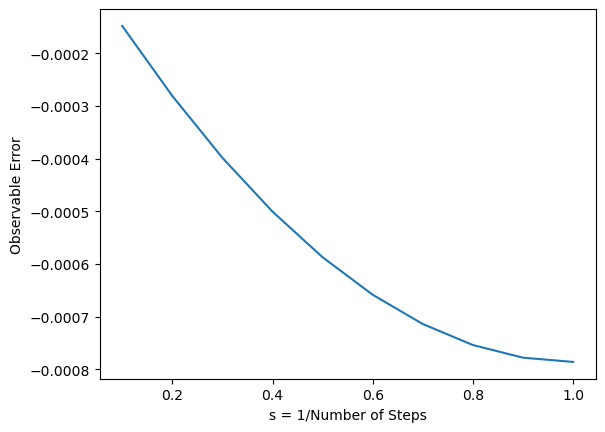

In [14]:
plt.plot(s_value_array, output_list_3)
plt.xlabel('s = 1/Number of Steps')
plt.ylabel('Observable Error')

## Chebyshev interpolation

`chebfun` seems a little excessive for our basic application. We can use `scipy.interpolate`

In [15]:
## Creates a list of n Chebyshev nodes in the interval [-halfwidth + center , halfwidth +center ]. 
# Input: a positive integer n and interval of given halfwidth and center,
# Returns: a list of the n Chebyshev nodes (zeros of the nth degree chebyshev polynomial on that interval)
def cheb_nodes(n, halfwidth = 1, center = 0):
    nodes = np.zeros(n)
    for j in range(n):
        nodes[n-j-1] = center + halfwidth * np.cos((2*j+1)*np.pi/(2*n))
    return nodes

# Computing the Interpolating Function

In [68]:
## Outputs the num_nodes degree Chebyshev approximation to the "order"-degree Trotter evolution.

def degree_N_Chebyshev(num_nodes, interval_width, Hterms, initial_state, time, local_obs, order = 2):
    
    # Generate array of nodes and initialise array to contain output values.
    slist = cheb_nodes(num_nodes, interval_width)
    ylist = np.zeros(num_nodes)
    
    # Generate the values we wish to interpolate.
    for k in range(0, num_nodes):
        # Compute the Trotter estimate at each Chebyshev node.
        ylist[k] = Trotterized_Expectation(Hterms, initial_state, time, slist[k], local_obs, order = trot_order)
    
    # Generate the interpolating function.
    interpolant = interp.BarycentricInterpolator(slist,ylist)
    
    return interpolant


## Outputs the extrapolated value at s=0.

def extrapolated_value(num_nodes, interval_width, Hterms, initial_state, time, local_obs, order = 2):

    Chebyshev_approx = degree_N_Chebyshev(num_nodes, interval_width, Hterms, initial_state, time, local_obs, order = 2)
    
    return Chebyshev_approx(0)
    
    
def degree_N_Chebyshev_error(num_nodes, interval_width, Hterms, initial_state, time, local_obs, error_param, order = 2):
    
    # Generate array of nodes and initialise array to contain output values.
    slist = cheb_nodes(num_nodes, interval_width)
    ylist = np.zeros(num_nodes)
    
    # Generate the values we wish to interpolate.
    for k in range(0, num_nodes):
        # Compute the Trotter estimate at each Chebyshev node.
        ylist[k] = Trotterized_Expectation(Hterms, initial_state, time, slist[k], local_obs, order = trot_order)+ rand.uniform(-error_param, error_param)
    
    # Generate the interpolating function.
    interpolant = interp.BarycentricInterpolator(slist,ylist)
    
    return interpolant    

## Interpolation and comparison with "best data point" in cheb set

a = 0.037037037037037035
Exact value: 1.5102568679523025
Interpolation value: 1.510256867952327
Best data value: 0.6053043796022771
Error for interpolation: -2.4424906541753444e-14
Error for raw data: -0.9049524883500254


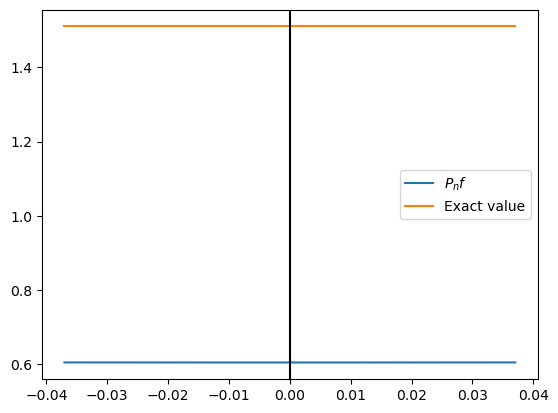

In [88]:
## This cell provides an example of the interpolation process.

trot_order = 2
time = 1
a = 1/min_step_number(nqubits, hlist, time)
print("a =",a)

num_nodes = 16 # Should always be even. Error should decrease exponentially with num_nodes

Chebyshev_approx = degree_N_Chebyshev(num_nodes, a, Hterms, initial_state, time, local_obs, order = trot_order)

# Exact expectation value.
exact_val = Exact_Expectation(Htot, initial_state, time, local_obs)
# Estimated expectatino value.
estimated_val = Chebyshev_approx(0)
# Best expectation value purely from direct measurement.
best_data_val = ylist[num_nodes//2]



error = exact_val - estimated_val
error_single_data = best_data_val - exact_val

print("Exact value:", exact_val)
print("Interpolation value:", estimated_val)
print("Best data value:", best_data_val)
print("Error for interpolation:", error)
print("Error for raw data:", error_single_data)

# Plot the resulting polynomial
x = np.linspace(-a,a,100)
plt.plot(x, interpolant(x), label=r'$P_n f$')
plt.plot(x, np.array([exact_val]*100), label='Exact value')
plt.legend()
plt.axvline(x=0, c="black")

# Error Scaling with Degree of Chebyshev Approximation

Text(0.5, 1.0, 'Error at Different Circuit Depths')

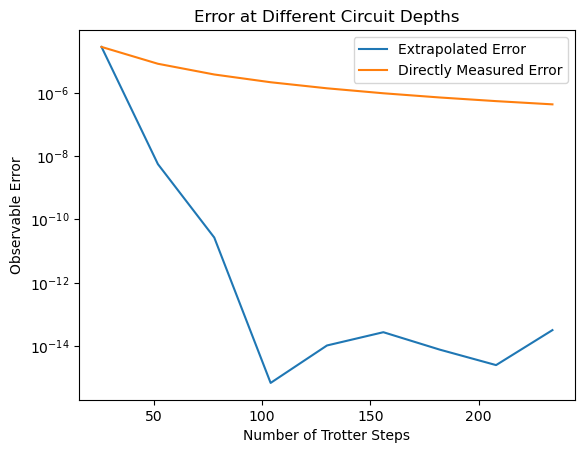

In [114]:
## Here we see how the error changes with the number of interpolating nodes/the degree of the approximating polynomial.

trot_order = 2
time = 1
a = 1/min_step_number(nqubits, hlist, time)
max_node_number = 20
Chebyshev_approx_array = []
estimated_value_list = []
degree_array = []
error_array = []
best_data_val_array = []
best_val_error_array = []


# Exact expectation value.
exact_val = Exact_Expectation(Htot, initial_state, time, local_obs)

# Generate a list of functions with increasing degree, then compute their estimate of the observable + error.
for k in range(1,int(max_node_number/2)):
    # Caluate the interpolating function for the degree 2*k Chebyshev interpolant.
    Chebyshev_approx_array.append( degree_N_Chebyshev(2*k, a, Hterms, initial_state, time, local_obs, order = trot_order) )
    # Calculate the estimated value from the s=0 value of the interpolation
    estimated_value_list.append( Chebyshev_approx_array[k-1](0) )
    degree_array.append( 2*k)
    # Calculate the error relative to the exact value.
    error_array.append( np.abs( exact_val - estimated_value_list[k-1] )  )
    
    # Now compute error associated with the best value from data for each corresponding degree approximation.
    s_list = cheb_nodes(2*k, a)
    best_data_val_array.append( Trotterized_Expectation(Hterms, initial_state, time, s_list[k], local_obs, order = trot_order)  )
    best_val_error_array.append( np.abs( exact_val - best_data_val_array[k-1] )  )

    
    
# Convert array into the circuit depth in terms of elementary exponentials.

circuit_depth_array = min_step_number(nqubits, hlist, time)*(1/2)*np.array( degree_array )


# Plot graphs.

plt.semilogy(circuit_depth_array, error_array,  label="Extrapolated Error")
plt.semilogy(circuit_depth_array, best_val_error_array, label="Directly Measured Error"  )
plt.xlabel('Number of Trotter Steps')
plt.ylabel('Observable Error')
plt.legend()
plt.title("Error at Different Circuit Depths")

# Extrapolation in the Presence of Error on Measurements

a = 0.05555555555555555


Text(0.5, 1.0, 'Extrapolated and Regular Error in Presence of Noise')

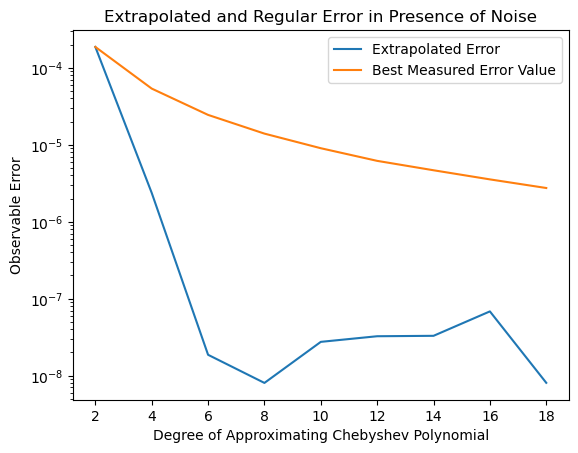

In [70]:
## In reality, the measurements are not perfect. Here we add some "noise" to the values we extrapolate through
## to determine how the extrapolation performs.

# Noise parameter; bounds the the maximum strength of the noise:
error_param = 10**(-7)

trot_order = 2
time = 1
a = 1/min_step_number(nqubits, hlist, time)
print("a =",a)
max_node_number = 20
Chebyshev_approx_array = []
estimated_value_list = []
degree_array = []
error_array = []
best_data_val_array = []
best_val_error_array = []


# Exact expectation value.
exact_val = Exact_Expectation(Htot, initial_state, time, local_obs)

# Generate a list of functions with increasing degree, then compute their estimate of the observable + error.
for k in range(1,int(max_node_number/2)):
    Chebyshev_approx_array.append( degree_N_Chebyshev_error(2*k, a, Hterms, initial_state, time, local_obs, error_param, order = trot_order) )
    estimated_value_list.append( Chebyshev_approx_array[k-1](0) )
    degree_array.append( 2*k)
    error_array.append( np.abs( exact_val - estimated_value_list[k-1] )  )
    
    # Now compute error associated with the best value from data for each corresponding degree approximation.
    s_list = cheb_nodes(2*k, a)
    best_data_val_array.append( Trotterized_Expectation(Hterms, initial_state, time, s_list[k], local_obs, order = trot_order) + rand.uniform(-error_param, error_param)  )
    best_val_error_array.append( np.abs( exact_val - best_data_val_array[k-1] )  )


    
# Plot graphs.

plt.semilogy(degree_array, error_array,  label="Extrapolated Error")
plt.semilogy(degree_array , best_val_error_array, label="Best Measured Error Value"  )
plt.xlabel('Degree of Approximating Chebyshev Polynomial')
plt.ylabel('Observable Error')
plt.legend()
plt.title("Extrapolated vs. Regular Error in Presence of Noise")

a = 0.05555555555555555
Exact value: 0.6053008769233661
Interpolation value: 0.6053008769233754
Best data value: 0.6053043796022771
Error for interpolation: -9.325873406851315e-15
Error for raw data: 3.5026789110270684e-06


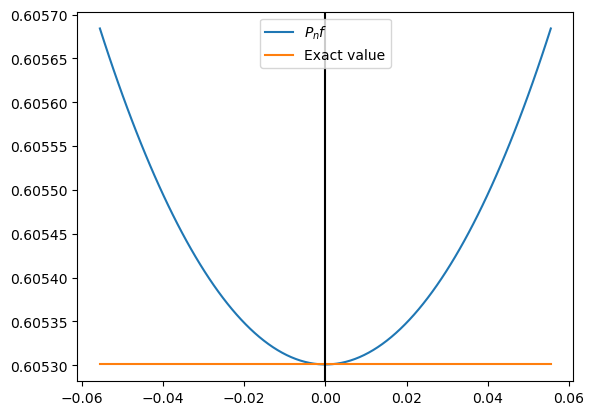

In [19]:
trot_order = 2
time = 1
a = 1/min_step_number(nqubits, hlist, time)
print("a =",a)

num_nodes = 16 # Should always be even. Error should decrease exponentially with num_nodes

slist = cheb_nodes(num_nodes, a)
ylist = np.zeros(num_nodes)
for k in range(0, num_nodes):
    # Compute the Trotter estimate
    ylist[k] = Trotterized_Expectation(Hterms, initial_state, time, slist[k], local_obs, order = trot_order)

interpolant = interp.BarycentricInterpolator(slist,ylist)

exact_val = Exact_Expectation(Htot, initial_state, time, local_obs)
estimated_val = interpolant(0)
best_data_val = ylist[num_nodes//2]

error = exact_val - estimated_val
error_single_data = best_data_val - exact_val

print("Exact value:", exact_val)
print("Interpolation value:", estimated_val)
print("Best data value:", best_data_val)
print("Error for interpolation:", error)
print("Error for raw data:", error_single_data)

# Plot the resulting polynomial
x = np.linspace(-a,a,100)
plt.plot(x, interpolant(x), label=r'$P_n f$')
plt.plot(x, np.array([exact_val]*100), label='Exact value')
plt.legend()
plt.axvline(x=0, c="black")

In [ ]:
# Parameters
nqubits = 4
h = 0
steps = 1000
T = 8

# Generate a list of random coefficients.
hlist = (np.random.rand(nqubits)*2 -1)*h

# Trotter pieces: group the odd and even Hamiltonian terms.

Even = sigma_dot_sigma(0, 1, nqubits)
for j in range(2,nqubits,2):
    Even += sigma_dot_sigma(j, (j+1)%nqubits, nqubits)

Odd = sigma_dot_sigma(1, 2%nqubits, nqubits)
for j in range(3,nqubits,2):
    Odd += sigma_dot_sigma(j, (j+1)%nqubits, nqubits)
    
Potential = np.sum([hlist[j]*sparse_pauli({j:'Z'}, nqubits) for j in range(nqubits)], axis = 0)

Hterms = [Even, Odd, Potential]

Even_terms = Even
Odd_terms = Odd


A = Uexact(heisenbergH(nqubits, hlist), T)
B = Utrot_long(Hterms, T, steps)

# Checking

In [ ]:
## Checking time evolution on n-qubits does decrease as the step number increases.
# Define initial parameters.
time = 10
local_obs = observable([{0: 'Z'},{nqubits-1: 'X'}, {1: 'X'} ], nqubits)
state = sparse_bitstring(list(np.arange(nqubits)), nqubits)

# Exact Evolution
Hamiltonian = heisenbergH(nqubits, hlist)
C_mat =  Uexact(Hamiltonian, time)

# Inexact Evolution
steps = min_step_number(nqubits, hlist, time)
D_mat = Utrot_long(Hlist, time, steps )


min_no_steps = min_step_number(nqubits, hlist, time)
max_s_value = 1/min_step_number(nqubits, hlist, time)

s_step_size = max_s_value/1000


s_value_array = np.arange(s_step_size, max_s_value, s_step_size)
step_value_array = [1/s for s in s_value_array]
D_array = [ Utrot_long(Hlist, time, step ) for step in step_value_array]

# Difference in norms of evolution operators
norm_diff_array = [sla.norm(C_mat-D,2) for D in D_array]

# Now calculate the difference between the exact and Trotterized expectation values.
exact_expectation = Exact_Expectation(Hamiltonian, state, time, local_obs)
observable_diff_array = [ exact_expectation - Trotterized_Expectation(Hlist, state, time, 1/x, local_obs, order = 1) for x in step_value_array]

# Plot the norm of the difference between the norms of exact and Trotterised evolution
#plt.plot(step_value_array, norm_diff_array )

# Plot the difference between the local observables of exact vs Trotterised.
plt.plot(step_value_array, observable_diff_array )
plt.xlabel('Number of Steps')
plt.ylabel('Observable Error')


## Basic example

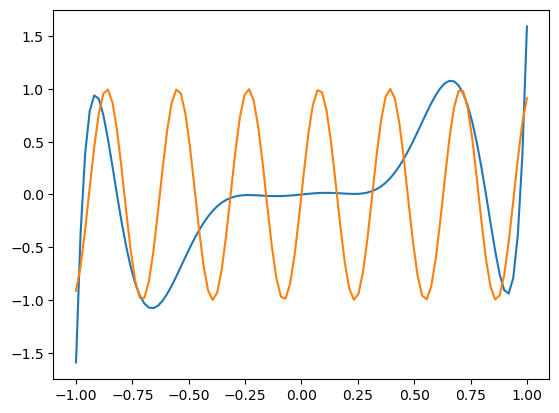

In [17]:
n = 10
xi = np.array(cheb_nodes(n))
yi = np.sin(20*xi)
interpolant = interp.BarycentricInterpolator(xi,yi)

x = np.linspace(-1,1,100)
interpolant(x)
plt.plot(x,interpolant(x))
plt.plot(x, np.sin(20*x))

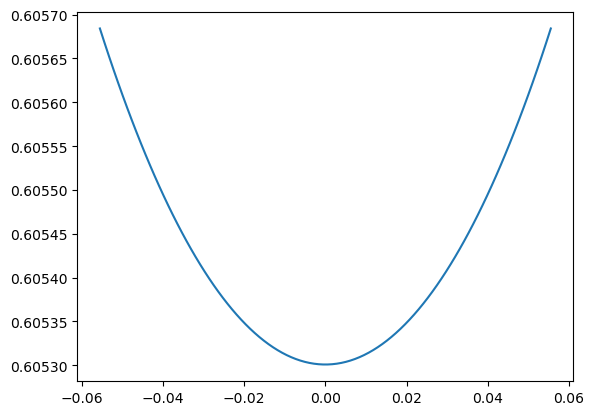

In [25]:
x = np.linspace(-a,a,100)
#interpolant(x)
plt.plot(x,Chebyshev_approx(x))


In [109]:
len(circuit_depth_array) - len(degree_array)

693